# Neural Networks

The previous weeks have helped you become familiar with basic Python, Linear Algebra, Computational Graphs and calculating gradients, Gradient Descent and Linear Classifiers. It's no surprise that all of them are used in Neural Networks. Let's get started!

This assignment considers neural networks with multiple layers. Each layer has multiple inputs and outputs, and can be broken down into two parts:

* A **linear module** that implements a linear transformation $z_j = (\sum_{i=1}^m x_i W_{i,j}) + W_{0j}$ specified by a weight matrix $W$ and a bias vector $W_0$. The output is $[z_1,\ldots,z_n]^T$

* An activation module that applies an activation function to the outputs of the linear module for some activation function $f$, such as Tanh or ReLU in the hidden layers or Softmax (see below) at the output layer. We write the output as: $[f(z_1),\ldots,f(z_n)]^T$ although technically, for some activation functions such as softmax, each output will depend on all the $z_i$, not just one.

We will use the following notation for quantities in a network:

* Inputs to the network are $x_1, \ldots, x_d$
* Number of layers is $L$
* There are $m^l$ inputs to layer $l$
* There are $n = m^{l+1}$ outputs to layer $l$
* The weight matrix for layer $l$ is $W^l$, an $m^l \times n^l$ matrix and the bias vector (offset) is $W_0^l$, an $n^l \times 1$ vector
* The outputs of the linear module for layer $l$ are known as **pre-activation values** and denoted $z^l$
* The activation function at layer $l$ is $f^l(\cdot)$
* Layer ll activations are $a^l = [f^l(z^l_1), \ldots, f^l(z^l_{n^l})]^T$
* The output of the network is the values $a^L = [f^L(z^L_1), \ldots, f^L(z^L_{n^L})]^T$
* Loss function *Loss*$(a, y)$ measures the loss of output values $a$ when the target is $y$

An example : 


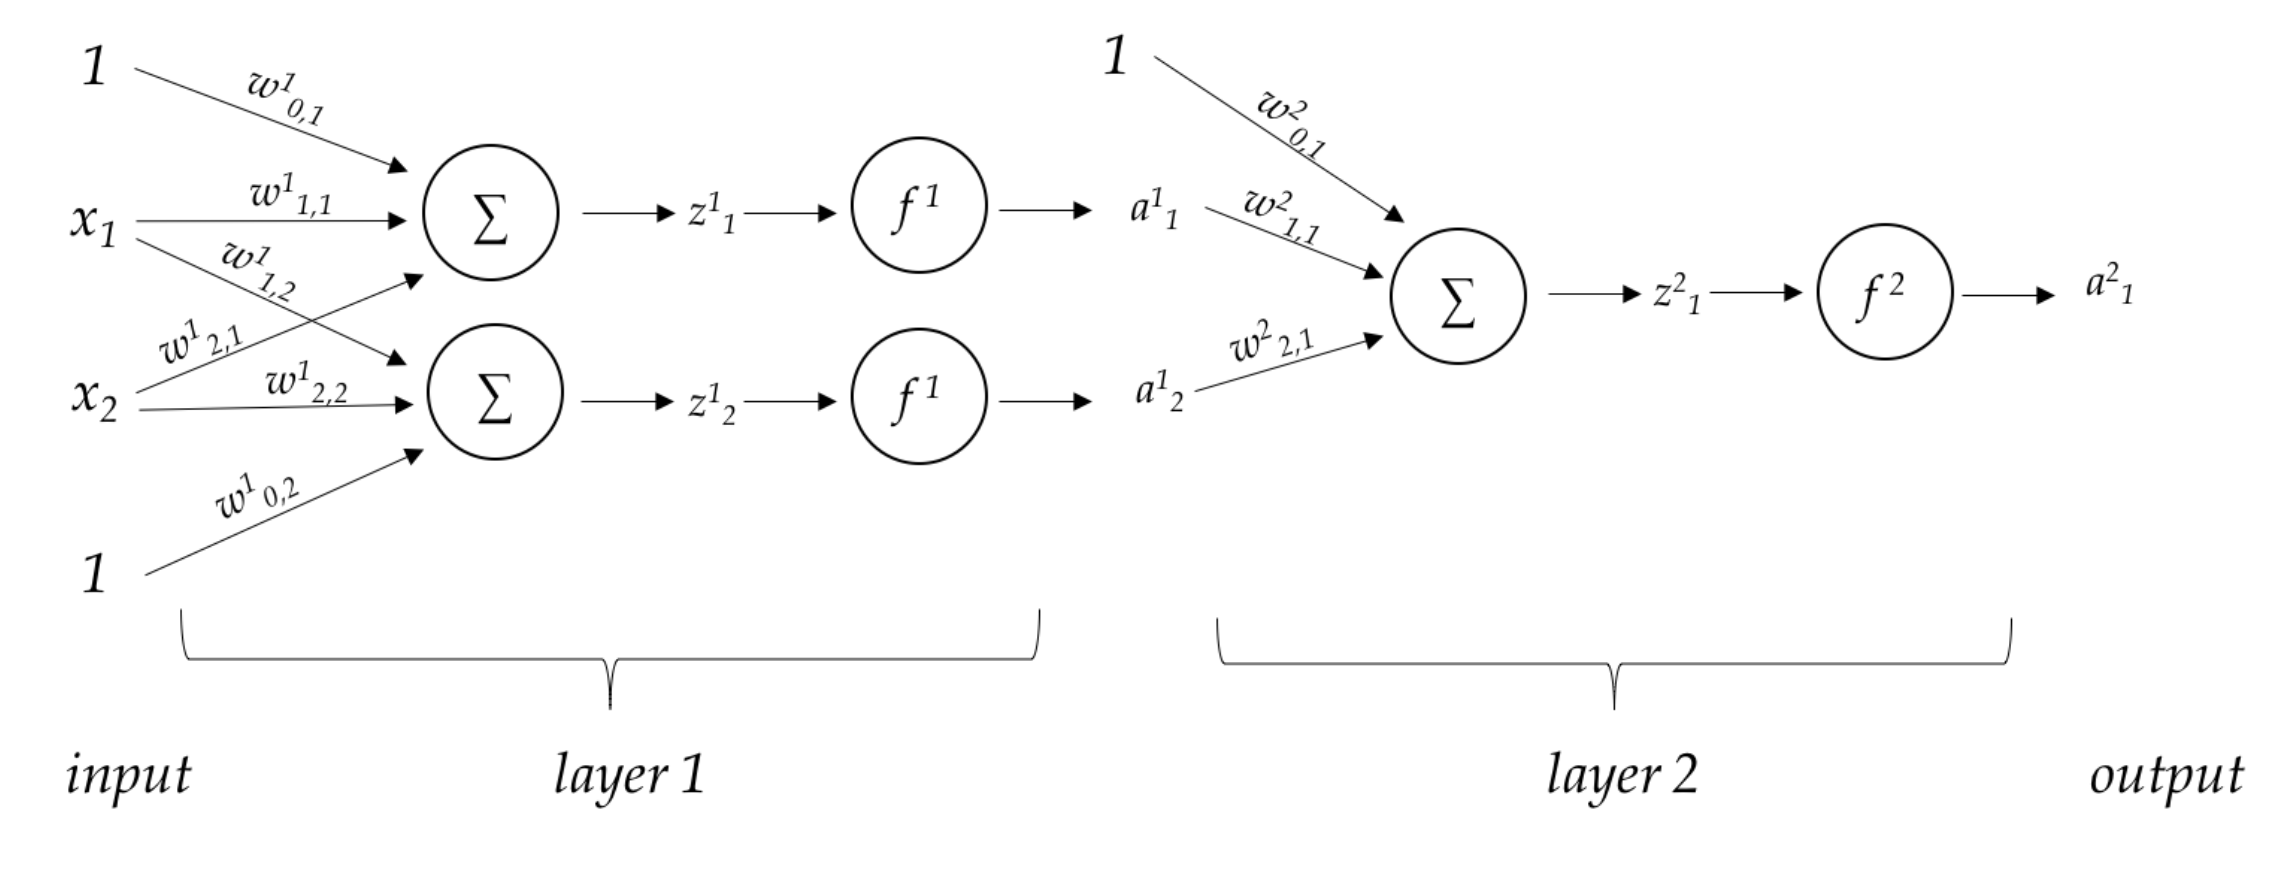

## Backpropogation

We have seen in the lecture notes how to train multi-layer neural networks as classifiers using stochastic gradient descent (SGD). One of the key steps in the SGD method is the evaluation of the gradient of the loss function with respect to the model parameters. In this problem, you will derive the backpropagation method for a general $L$-layer neural network. We'll exploit the decomposition of the network into linear and activation modules that we introduced at the start of this assignment. Remember that we've defined the shapes of the various quantities at the start of the assignment.

* Each linear module has a `forward` method that takes in a column vector of activations $A$ (from the previous layer) and returns a column vector $Z$ of pre-activations; it can also store its input or output vectors for use by other methods (e.g., for subsequent backpropagation).

* Each activation module has a `forward` method that takes in a column vector of pre-activations $Z$ and returns a column vector $A$ of activations; it can also store its input or output vectors for use by other methods (e.g., for subsequent backpropagation).

* Each linear module has a `backward` method that takes in a column vector $\frac{\partial Loss}{\partial Z}$ and returns a column vector $\frac{\partial Loss}{\partial A}$. This module also computes and stores $\frac{\partial Loss}{\partial W}$ and 
$\frac{\partial Loss}{\partial W_0}$, the gradients with respect to the weights.

* Each activation module has a `backward` method that takes in a column vector $\frac{\partial Loss}{\partial A}$ and returns a column vector $\frac{\partial Loss}{\partial Z}$.

The backpropagation algorithm will consist of:

* Calling the `forward` method of each module in turn, feeding the output of one module as the input to the next; starting with the input values of the network. After this pass, we have a predicted value for the final network output.

* Calling the `backward` method of each module in reverse order, using the returned value from one module as the input value of the previous one. The starting value for the backward method is $\partial Loss(a^L, y) \, / \, \partial a^L$, where $a^L$ is the activation of the final layer (computed during the forward pass) and $y$ is the desired output (the label).

Enough explaining, let's start coding!

In [ ]:
class Module:
    def sgd_step(self, lrate): pass  # For modules w/o weights

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import os

## Linear Modules: ##
Each linear module has a forward method that takes in a batch of activations A (from the previous layer) and returns a batch of pre-activations Z.

Each linear module has a backward method that takes in dLdZ and returns dLdA. This module also computes and stores dLdW and dLdW0, the gradients with respect to the weights.

In [ ]:
class Linear(Module):
    def __init__(self, m, n):
        self.m, self.n = (m, n)                                 # (in size, out size)
        self.W0 = np.zeros([self.n, 1])                         # (n x 1)
        self.W = np.random.normal(0, 1.0 * m ** (-.5), [m, n])  # (m x n)

    def forward(self, A):
        self.A = A                        # (m x b)  Hint: make sure you understand what b stands for
        Z = np.dot(self.W,A) + self.W0
        return Z                          # Your code (n x b)

    def backward(self, dLdZ):                                        # dLdZ is (n x b), uses stored self.A
        m = self.A[1]
        self.dLdW = 1/m * np.dot(dLdZ,self.A.T)                      # Your code
        self.dLdW0 = (1/m)*np.sum(dLdZ, axis=1, keepdims=True);      # Your code
        dLdA = np.dot(self.W.T,dLdZ)
        return dLdA                                                  # Your code: return dLdA (m x b)

    def sgd_step(self, lrate):                         # Gradient descent step
        self.W =  self.W - lrate * self.dLdW           # Your code
        self.W0 = self.W0 - lrate * self.dLdW0         # Your code
        return self.W, self.W0



## Activation functions: ##
Each activation module has a forward method that takes in a batch of pre-activations Z and returns a batch of activations A.

Each activation module has a backward method that takes in dLdA and returns dLdZ, with the exception of SoftMax, where we assume dLdZ is passed in.

### Tanh: ###

In [ ]:
class Tanh(Module):            # Layer activation
    def forward(self, Z):
        A = np.tanh(Z)
        return A

    def backward(self, dLdA):   # Uses stored self.A
        dLdA = 1-self.A**2
        return dLdA             # Your code: return dLdZ (?, b)

### ReLU: ###

In [ ]:
class ReLU(Module):              # Layer activation
    def forward(self, Z):
        self.Z = Z
        A = np.maximum(0,Z)      # Your code: (?, b)
        return A

    def backward(self, dLdA):    # uses stored self.A
        dLdZ = np.array(dLdA , copy = True)
        dLdZ[self.Z <=  0] = 0
        assert(dLdZ.shape == self.Z.shape)
        return dLdZ              # Your code: return dLdZ (?, b)

###SoftMax: ###
For `SoftMax.class_fun()`, given the column vector of class probabilities for each point (computed by Softmax), return a vector of the classes (integers) with the highest probability for each point.

In [ ]:
class SoftMax(Module):        # Output activation
    def forward(self, Z):
        self.Z = Z
        e_x = np.exp(Z)
        A = e_x/np.sum(e_x)
        return A              # Your code: (?, b)

    def backward(self, dLdZ): # Assume that dLdZ is passed in
        exp_element=np.exp(dLdZ-dLdZ.max())
        return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))
        

    def class_fun(self, Ypred):                    # Return class indices
        Y = np.zeros((Ypred.size, Ypred.max() + 1))
        Y[np.arange(Ypred.size), Ypred] = 1
        Y = Y.T
        
        return Y                                    # Your code: (1, b)

## Loss Functions: 
Each loss module has a forward method that takes in a batch of predictions Ypred (from the previous layer) and labels Y and returns a scalar loss value.

The NLL module has a backward method that returns dLdZ, the gradient with respect to the preactivation to SoftMax (note: not the activation!), since we are always pairing SoftMax activation with NLL loss

### NLL: ###

In [ ]:
class NLL(Module):       # Loss
    def forward(self, Ypred, Y):
        self.Ypred = Ypred
        self.Y = Y
        m = Y.shape[1]
        cost = (-1/m)*np.sum(np.multiply(Y, np.log(Ypred)) + np.multiply(1 - Y, np.log(1 - Ypred)))
        return cost    # Your code

    def backward(self):  # Use stored self.Ypred, self.Y
        dYpred = - (np.divide(self.Y, self.Ypred) - np.divide(1 - self.Y, 1 - self.Ypred))
        return dYpred      # Your code

## Neural Network: ##

Implement SGD. Randomly pick a data point Xt, Yt by using np.random.randint to choose a random index into the data. Compute the predicted output Ypred for Xt with the forward method. Compute the loss for Ypred relative to Yt. Use the backward method to compute the gradients. Use the sgd_step method to change the weights. Repeat.

In [ ]:
class Sequential:
    def __init__(self, modules, loss):            # List of modules, loss module
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):  # Train
        D, N = X.shape
        for it in range(iters):
          obj = Linear(self.Module)
          W , b = obj.sgd_step(lrate)
          return W,b                              # Your code

    def forward(self, Xt):                        # Compute Ypred
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):                    # Update dLdW and dLdW0
        # Note reversed list of modules
        for m in self.modules[::-1]: delta = m.backward(delta)

    def sgd_step(self, lrate):                    # Gradient descent step
        for m in self.modules: m.sgd_step(lrate)
          obj = Linear(self.Module)
          W , b = obj.sgd_step(lrate)
          return W,b

    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        # Utility method to print accuracy on full dataset, should
        # improve over time when doing SGD. Also prints current loss,
        # which should decrease over time. Call this on each iteration
        # of SGD!
        if it % every == 1:
            cf = self.modules[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            print('Iteration =', it, '\tAcc =', acc, '\tLoss =', cur_loss, flush=True)

## Training on MNIST

You didn't think that we were going to forget MNIST, did you? We'll be training and testing our framework on this dataset, and we'll be following the same architecture as the one described in 3Blue1Brown's videos (just for consistency, we could have chosen a more complicated one, our framework allows for that) with 2 hidden layers, each of 16 neurons.

We'll be using the same dataset as in Week 0, however, this time, we'll need to organise the data slightly differently than what we did there, namely, into a matrix with $d$ number of column vectors, each of them having a length of 784 ($d$ is just the number of images we have in the training/testing dataset, which is 50000 during training and 10000 during testing)

The labels also need a bit of changing, since the outputs of our neural network are arrays of size 10 (where the value at each index represents the probability of the image representing that digit). In order to calculate the loss, we'll have to represent the expected output as an array of size 10 itself, so do keep that in mind while training and testing.

For the MNIST dataset, please take it from the following link 

https://pjreddie.com/projects/mnist-in-csv/. Use the training set to train your neural network and the testing set to test.

We can construct the network and train it as follows:

```
# build a 3-layer network
net = Sequential([Linear(784,16), ReLU(),
                  Linear(16,16), ReLU(),
    	          Linear(16,10), SoftMax()], NLL())
# train the network on data and labels
net.sgd(X, Y, iters = 100, lrate = 0.005) #Play around with these values if you wish
```

Note that X and Y here are $d \times 784$ and $d \times 10$ matrices respectively, where $d$ is the number of images in the training/testing dataset.

For testing, use the forward method of the network to get the output, and then use `SoftMax.class_fun()` to get the index with the highest probability, and compare it with the original label (do it for all the training examples, and report the accuracy)